# Exercício 4 - PSI3471
### Exercício feito individualmente
#### Henrique Schneider Marx 14578432

Começamos importando as bibliotecas necessárias.

In [1]:
import numpy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torchvision import datasets, transforms

In [2]:
# Ajuste de hiperparâmetros

# passo de adaptação
eta = 0.001

# Tamanho do mini-batch
Nb = 64

# Tamanho do mini-batch usado no teste
Nb_test = 1024

# Número de épocas
Ne = 10

In [3]:
dir_data = "~/temp"

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        dir_data,
        train=True,
        download=True,
        transform=transforms.Compose(            
            [transforms.ToTensor()]
        ),
    ),
    batch_size=Nb,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        dir_data,
        train=False,  # Altere para False para carregar o conjunto de testes
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]),
    ),
    batch_size=Nb_test,  # Use o tamanho do mini-batch de teste
    shuffle=False,  # Geralmente não embaralhamos os dados de teste
)

In [4]:
class Model(nn.Module):
    def __init__(self):
        # Necessário chamar __init__() da classe mãe
        super().__init__()
        
        # Camada convolucional, seguida de ReLU e Pooling
        # Entra uma imagem 28x28. Com filtro 5x5, padding de 2
        # e stride 1, a saída também tem 28x28. Após o pooling,
        # a saída fica com 14x14. A entrada tem 1 canal e a
        # saída tem 16.
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        
        # Camada convolucional
        # Entrada 14x14, saída 7x7 após o pooling.
        # 16 canais de entrada e 32 de saída.
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        # Camada totalmente conectada
        # Na entrada, há 32 canais de 7x7 elementos
        # e a saída tem 10 neurônios.
        self.out = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        # Aplica primeira camada convolucional
        x = self.conv1(x)
        
        # Aplica segunda camada convolucional
        x = self.conv2(x)        
        
        # Transforma os tensores 32x7x7 em
        # vetores para serem usados na entrada da
        # camada totalmente conectada. Vale notar
        # que a primeira dimensão dos tensores de
        # dados é usada para representar os diversos
        # elementos de um batch, por isso permanece
        # inalterada.
        x = x.view(x.size(0), -1)       
        
        # Calcula a saída e retorna
        output = self.out(x)
        return output

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instanciando modelo
model = Model().to(device)

# Função custo para treinamento
loss_function = nn.CrossEntropyLoss()

# Otimizador
optimizer = torch.optim.Adam(model.parameters(), lr = eta)

Época: 0 [0/60000 (0%)]	Loss: 2.307441
Época: 0 [6400/60000 (11%)]	Loss: 0.826344
Época: 0 [12800/60000 (21%)]	Loss: 0.657384
Época: 0 [19200/60000 (32%)]	Loss: 0.419888
Época: 0 [25600/60000 (43%)]	Loss: 0.712178
Época: 0 [32000/60000 (53%)]	Loss: 0.539531
Época: 0 [38400/60000 (64%)]	Loss: 0.464622
Época: 0 [44800/60000 (75%)]	Loss: 0.338615
Época: 0 [51200/60000 (85%)]	Loss: 0.337329
Época: 0 [57600/60000 (96%)]	Loss: 0.328621
Época: 1 [0/60000 (0%)]	Loss: 0.456612
Época: 1 [6400/60000 (11%)]	Loss: 0.481114
Época: 1 [12800/60000 (21%)]	Loss: 0.298780
Época: 1 [19200/60000 (32%)]	Loss: 0.431254
Época: 1 [25600/60000 (43%)]	Loss: 0.206264
Época: 1 [32000/60000 (53%)]	Loss: 0.337194
Época: 1 [38400/60000 (64%)]	Loss: 0.350331
Época: 1 [44800/60000 (75%)]	Loss: 0.342220
Época: 1 [51200/60000 (85%)]	Loss: 0.293040
Época: 1 [57600/60000 (96%)]	Loss: 0.248849
Época: 2 [0/60000 (0%)]	Loss: 0.315265
Época: 2 [6400/60000 (11%)]	Loss: 0.220140
Época: 2 [12800/60000 (21%)]	Loss: 0.369575
Época:

Text(0, 0.5, 'Loss')

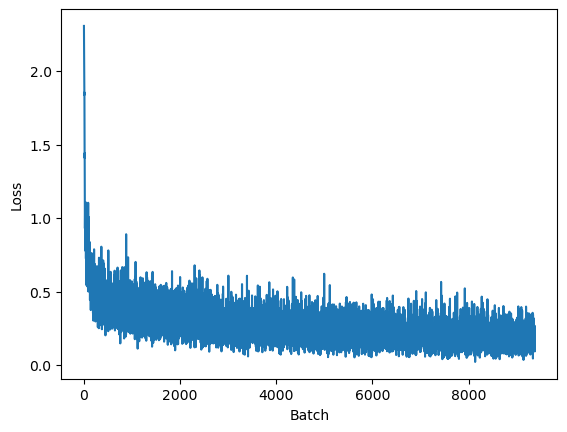

In [6]:
# Lista usada para guardar o valor da função custo ao longo das iterações
losses = []

# Loop das épocas
for epoch in range(Ne):
    # Loop dos mini batches
    for n, (X, d) in enumerate(train_loader):
        # Envia os dados para a GPU, caso ela exista
        X = X.to(device=device)
        d = d.to(device=device)

        # Ajuste de dimensões
        # (elementos do mini batch x 1 canal x 28 x 28)
        X = X.view(-1, 1, 28, 28)

        # Coloca o modelo em modo treinamento
        model.train()

        # Zera informações de gradientes
        model.zero_grad()

        # Calcula a saída
        y = model(X)

        # Calcula o valor da função custo
        loss = loss_function(y, d)

        # Calcula os gradientes
        loss.backward()

        # Atualiza os pesos do modelo
        optimizer.step()

        # Armazena o valor da função custo
        losses.append(loss.item())

        # Mostra o valor da função custo a cada 100 iterações
        if n % 100 == 0:
            N_all = len(train_loader.dataset)
            n_ex = n * len(X)
            p = 100. * n / len(train_loader)
            print(
                f"Época: {epoch} [{n_ex}/{N_all} ({p:.0f}%)]\tLoss: {loss:.6f}"
            )            

plt.figure()
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")

In [7]:
# Variável usada para contabilizar o número de acertos
correct = 0

# Loop dos mini batches
for n, (X, d) in enumerate(test_loader):
    # Envia os dados para a GPU, caso ela exista
    X = X.to(device=device)
    d = d.to(device=device)

    # Ajuste de dimensões
    X = X.view(-1, 1, 28, 28)

    # Coloca o modelo em modo de inferência
    model.eval()

    # Calcula a saída
    y = model(X)

    # Cálculo do número de acertos:
    # 1) Obtém o índice do elemento máximo para cada exemplo do minibatch
    pred = torch.max(y, 1, keepdim=True)[1]     
    # 2) Conta o número de acertos e acumula na variável correct
    # pred.eq(d.view_as(pred)) é um tensor booleano. Dessa forma, o número de
    # acertos é obtido somando seus elementos. Valores True são tratados como 1. 
    correct += pred.eq(d.view_as(pred)).cpu().sum().item()

# Mostra o desempenho obtido no teste    
accuracy = 100. * correct / len(test_loader.dataset)
print(f"Acurácia: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)")

Acurácia: 9087/10000 (91%)
